In [17]:
# import libraries
import pandas as pd
import numpy as np
import os
from tableone import TableOne 
import matplotlib.pyplot as plt

In [20]:
# Get the unique participantIds, years, and months
participant_ids = data['participantId'].unique()
years = data['year'].unique()
months = data['month'].unique()

In [24]:
# Function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

In [25]:
# Add season column
data['season'] = data['month'].apply(get_season)

In [ ]:
# Group by participantId and dp, and count unique months across years
summary = data.groupby(['participantId', 'dp']).apply(lambda x: x[['year', 'month']].drop_duplicates().shape[0]).reset_index(name='nMonths')

In [28]:
# recode Antidepressant as object
data['Antidepressant'] = data['Antidepressant'].astype('object')
data['Antidepressant'] = data['Antidepressant'].replace({1: 'yes', 0: 'no'})
# recode gender to male and female. 1: male, 2: female
data['gender'] = data['gender'].replace({1: 'male', 2: 'female'})

# Select demogrpahic and medication columns, drop duplicates based on participant id
df_demo = data[[
    'participantId',
    'vehicleName',
    'dp',
    'gender',
    'educ',
    'age',
    'Antidepressant',
    'Total',
    'season'
]].drop_duplicates(subset='participantId').reset_index(drop=True).copy()

### Viz Monthly distribution data

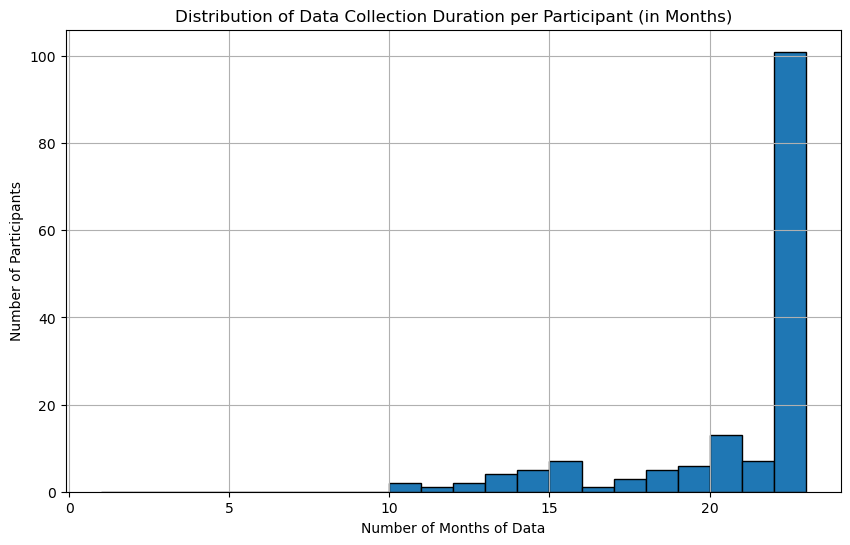

In [29]:
# Combine 'year' and 'month' to create a 'year_month' period
data['year_month'] = pd.to_datetime(data[['year', 'month']].assign(day=1))

# Calculate the number of unique months each participant has data for
px_months = data.groupby('participantId')['year_month'].nunique()

# Visualize the distribution of data collection durations (in months) for each px
plt.figure(figsize=(10, 6))
px_months = px_months.dropna()  # Remove NaN values before plotting
px_months.hist(bins=range(1, int(px_months.max()) + 1), edgecolor='black')
plt.title('Distribution of Data Collection Duration per Participant (in Months)')
plt.xlabel('Number of Months of Data')
plt.ylabel('Number of Participants')
#plt.savefig('Distribution of Data Collection Duration per Participant (in Months).png',dpi=400)
plt.show()

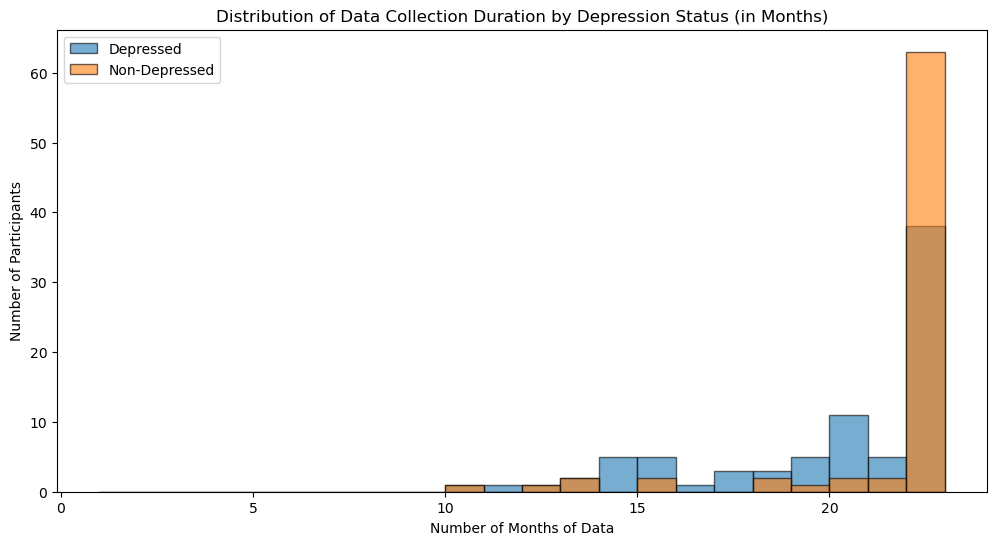

In [30]:
# To show the distribution by depression group
# Filter data by depression status
depression_group = data[data['dp'] == 'yes']
non_depression_group = data[data['dp'] == 'no']

# Get the number of months data for each group
depression_months = depression_group.groupby('participantId')['year_month'].nunique()
non_depression_months = non_depression_group.groupby('participantId')['year_month'].nunique()

# Plot the distribution for each group
plt.figure(figsize=(12, 6))
plt.hist(depression_months, bins=range(1, int(depression_months.max()) + 1), alpha=0.6, label='Depressed', edgecolor='black')
plt.hist(non_depression_months, bins=range(1, int(non_depression_months.max()) + 1), alpha=0.6, label='Non-Depressed', edgecolor='black')
plt.title('Distribution of Data Collection Duration by Depression Status (in Months)')
plt.xlabel('Number of Months of Data')
plt.ylabel('Number of Participants')
plt.legend()
#plt.savefig('Distribution of Data Collection Duration by Depression Status (in Months).png',dpi=600)
plt.show()


### CDR

In [32]:
cdr = input_cdr[['map_id', 
                 'cdrsum', 
                 'cdrglob',
                 'otdate']].dropna().drop_duplicates().reset_index(drop = True)

In [33]:
cdr['otdate'] = pd.to_datetime(cdr['otdate'])
# Define the target date
target_date = pd.to_datetime('2022-07-01')

# Define a function to find the row of data that closest to the target date 
def closest_date(row):
    return row.loc[row['otdate'].sub(target_date).abs().idxmin()]

# Apply the function to each px(id) 
closest_rows = cdr.groupby('map_id')[['map_id', 'cdrsum', 'cdrglob', 'otdate']].apply(closest_date).reset_index(drop=True)

# Create a new df with the rows with closest date
cdr = pd.DataFrame(closest_rows)

In [34]:
tmp_demo_cdr = pd.merge(df_demo, cdr, left_on='participantId',
         right_on = 'map_id',
         how='left').drop_duplicates()

In [35]:
# Rename the vars
adrc_cdr = adrc_cdr.rename(columns={'TESTDATE': 'otdate'})
adrc_cdr['otdate'] = pd.to_datetime(adrc_cdr['otdate'], format='%d-%b-%y')
# Apply the function to each px
closest_rows_adrc = adrc_cdr.groupby('ID')[['ID', 'otdate', 'cdr', 'sumbox']].apply(closest_date).reset_index(drop=True)

# Create a new df with the rows with closest date
adrc_cdr = pd.DataFrame(closest_rows_adrc)

In [36]:
demo_cdr = pd.merge(tmp_demo_cdr.drop(columns=['otdate', 'map_id']), 
                    adrc_cdr[['ID', 'cdr', 'sumbox']], 
                    left_on='participantId',
         right_on = 'ID',
         how='left').drop_duplicates()

In [37]:
demo_cdr['cdrsum'] = demo_cdr['cdrsum'].fillna(demo_cdr['sumbox'])
demo_cdr['cdrglob'] = demo_cdr['cdrglob'].fillna(demo_cdr['cdr'])

In [38]:
demo_cdr = demo_cdr.drop(columns=['ID', 'cdr', 'sumbox'])

### ADI

In [41]:
# Merge adi to df with demographics and cdr scores.
demo_cdr_adi = pd.merge(demo_cdr, 
                        input_adi[[
                        'id',
                        'ADI_NATRANK',
                        'ADI_STATERNK']], 
                        left_on='participantId',
                        right_on = 'id',
                        how='left').drop_duplicates()

### Add Number of Months for each px to demo_cdr_adi

In [43]:
demo_cdr_adi_months = pd.merge(demo_cdr_adi, 
                        summary[['participantId', 'nMonths']], 
                        on='participantId',
                        how='left').drop_duplicates()

In [48]:
# Specify the columns to include in the table
columns = ['age', 'gender', 
           'educ', 'Total', 
           'Antidepressant',  
           'cdrsum', 
           'cdrglob', 
           'ADI_NATRANK', 
           'ADI_STATERNK', 
           'nMonths']  
categorical = ['gender', 'Antidepressant', 
               'cdrglob'
              ]  
groupby = 'dp'  # stratify by dp 
decimals = {
    'age': 2,
    'gender': 2,
    'educ': 2,
    'Total': 2,
    'Antidepressant': 2,
    'cdrsum': 2, 
    'cdrglob': 2,            
    'ADI_NATRANK': 2, 
    'ADI_STATERNK': 2,
    
}
# Create TableOne
table_demo_cdr_adi_months = TableOne(demo_cdr_adi_months, columns=columns, categorical=categorical, groupby=groupby, decimals=decimals, pval=True)

# Print 
print(table_demo_cdr_adi_months.tabulate(tablefmt="fancy_grid"))

╒═════════════════════════╤════════╤═══════════╤═══════════════╤═══════════════╤═══════════════╤═══════════╕
│                         │        │ Missing   │ Overall       │ no            │ yes           │ P-Value   │
╞═════════════════════════╪════════╪═══════════╪═══════════════╪═══════════════╪═══════════════╪═══════════╡
│ n                       │        │           │ 157           │ 76            │ 81            │           │
├─────────────────────────┼────────┼───────────┼───────────────┼───────────────┼───────────────┼───────────┤
│ age, mean (SD)          │        │ 0         │ 72.93 (5.36)  │ 75.84 (5.09)  │ 70.20 (4.00)  │ <0.001    │
├─────────────────────────┼────────┼───────────┼───────────────┼───────────────┼───────────────┼───────────┤
│ gender, n (%)           │ female │           │ 83 (52.87)    │ 26 (34.21)    │ 57 (70.37)    │ <0.001    │
├─────────────────────────┼────────┼───────────┼───────────────┼───────────────┼───────────────┼───────────┤
│                  

In [54]:
# Filter the data where antidepressant == 'no'
antidepressant_no = demo_cdr_adi_months[demo_cdr_adi_months['Antidepressant'] == 'no']

# Calculate the mean age
mean_age_antidepressant_no = antidepressant_no['age'].mean()

print(f"Mean age when antidepressant == 'no': {mean_age_antidepressant_no}")

Mean age when antidepressant == 'no': 73.26388888888889


In [50]:
# Filter the data where antidepressant == 'yes'
antidepressant_yes = demo_cdr_adi_months[demo_cdr_adi_months['Antidepressant'] == 'yes']

# Calculate the mean age
mean_age_antidepressant_yes = antidepressant_yes['age'].mean()

print(f"Mean age when antidepressant == 'yes': {mean_age_antidepressant_yes}")

Mean age when antidepressant == 'yes': 69.23076923076923


In [53]:
antidepressant_yes['gender']

46       male
74     female
99     female
109    female
118    female
120    female
129      male
142    female
144    female
148    female
149      male
153      male
154      male
Name: gender, dtype: object

In [46]:
# Select driving columns, drop duplicates based on participant id
df_driving = data[[
    'participantId',
     'vehicleName',
     'dp',
     'nHardcoreBrake',
     'nHardcornering',
     'Days_driven_per_month',
     'nTrips_1mi',
     'nTrips_1to5mi',
     'randomEntropy',
     'radiusOfGyration',
     'maxDistanceFromHome',
     'maxDistance',
     'numberOfUniqueDestinations',
    'season'
]].drop_duplicates().reset_index(drop=True).copy()

In [47]:
# Specify the columns to include in the table
columns = [
    'dp',
    'nHardcoreBrake',
    'nHardcornering',
    'Days_driven_per_month',
    'nTrips_1mi',
    'nTrips_1to5mi',
    'randomEntropy',
    'radiusOfGyration',
    'maxDistanceFromHome',
    'maxDistance',
    'numberOfUniqueDestinations',
    'season'
]
categorical = ['dp','season']  # Specify categorical columns
groupby = 'dp'  # Group by this column

# Specify decimal places for each variable
decimals = {
    'nHardcoreBrake': 4,
    'nHardcornering': 4,
    'Days_driven_per_month': 2,
    'nTrips_1mi': 2,
    'nTrips_1to5mi': 2,
    'randomEntropy': 2,
    'radiusOfGyration': 2,
    'maxDistanceFromHome': 2,
    'maxDistance': 2,
    'numberOfUniqueDestinations': 2
}
# Create TableOne
table_driving = TableOne(df_driving, columns=columns, categorical=categorical, decimals=decimals, groupby=groupby, pval=True)

# Print the table
print(table_driving.tabulate(tablefmt="fancy_grid"))

╒═══════════════════════════════════════╤════════╤═══════════╤══════════════════╤══════════════════╤══════════════════╤═══════════╕
│                                       │        │ Missing   │ Overall          │ no               │ yes              │ P-Value   │
╞═══════════════════════════════════════╪════════╪═══════════╪══════════════════╪══════════════════╪══════════════════╪═══════════╡
│ n                                     │        │           │ 3329             │ 1700             │ 1629             │           │
├───────────────────────────────────────┼────────┼───────────┼──────────────────┼──────────────────┼──────────────────┼───────────┤
│ dp, n (%)                             │ no     │           │ 1700 (51.1)      │ 1700 (100.0)     │                  │ <0.001    │
├───────────────────────────────────────┼────────┼───────────┼──────────────────┼──────────────────┼──────────────────┼───────────┤
│                                       │ yes    │           │ 1629 (48.9)  